# 4.3 Word Vector Lab

## Goal

The following notebook will load a dictionary (lexicon) from `dict.txt` and build simple word vectors, so we can:

1. Discover the most similar word to a test word
2. Do basic word arithmetic (vector mathematics)
3. Validate results with a similarity heatmap

**Side Note:** The provided data, `dict.txt`, file is a word list, one word per line, so the vectors are built from the text itself. This notebook will be using character n-grams.

# Setup

Will import libraries for vector mathematics and plotting.

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load Data (Lexicon)

The following will load the words from `dict.txt` into a list. It will also remove the whitespace and ignore blank lines.

In [85]:
# Relative path
file_path = "dict.txt"

lexicon = []
with open(file_path, "r", encoding="utf-8") as f:
    for line in f:
        word = line.strip()
        if word != "":
            lexicon.append(word)

print("Total words loaded:", len(lexicon))
print("First 100 words:", lexicon[:100])

Total words loaded: 25087
First 100 words: ['a', 'aaa', 'aaas', 'aarhus', 'aaron', 'aau', 'aba', 'ababa', 'aback', 'abacus', 'abalone', 'abandon', 'abase', 'abash', 'abate', 'abater', 'abbas', 'abbe', 'abbey', 'abbot', 'abbott', 'abbreviate', 'abc', 'abdicate', 'abdomen', 'abdominal', 'abduct', 'abe', 'abed', 'abel', 'abelian', 'abelson', 'aberdeen', 'abernathy', 'aberrant', 'aberrate', 'abet', 'abetted', 'abetting', 'abeyance', 'abeyant', 'abhorred', 'abhorrent', 'abide', 'abidjan', 'abigail', 'abject', 'ablate', 'ablaze', 'able', 'ablution', 'abner', 'abnormal', 'abo', 'aboard', 'abode', 'abolish', 'abolition', 'abominable', 'abominate', 'aboriginal', 'aborigine', 'aborning', 'abort', 'abound', 'about', 'above', 'aboveboard', 'aboveground', 'abovementioned', 'abrade', 'abraham', 'abram', 'abramson', 'abrasion', 'abrasive', 'abreact', 'abreast', 'abridge', 'abridgment', 'abroad', 'abrogate', 'abrupt', 'abscess', 'abscissa', 'abscissae', 'absence', 'absent', 'absentee', 'absenteeism', 

# Build Word Vectors

Since `dict.txt` is just a list of words, the vectors are created using character 3-grams.
Some quick examples: "king" -> "kin", "ing"

Each word becomes a numeric vector where each position stores a 3-gram count. This makes it possible to compare words mathematically even when the dataset only contains a lexicon.

In [88]:
def get_ngrams(word, n=3):
    grams = []
    if len(word) < n:
        return grams
    i = 0
    while i <= len(word) - n:
        grams.append(word[i:i+n])
        i += 1
    return grams

## Create a vocabulary of n-grams

We will be collecting the most common n-grams, so vectors stay a reasonable size.

In [91]:
from collections import Counter

n = 3
ngram_counter = Counter()

# Will count ngrams across the lexicon
for w in lexicon:
    grams = get_ngrams(w.lower(), n)
    for g in grams:
        ngram_counter[g] += 1

# Will keep top n-grams to limit vector size
MAX_NGRAMS = 2000
most_common_ngrams = [g for g, c in ngram_counter.most_common(MAX_NGRAMS)]

ngram_to_index = {}
for idx, gram in enumerate(most_common_ngrams):
    ngram_to_index[gram] = idx

print("Total n-grams kept:", len(ngram_to_index))
print("Example of common n-grams:", most_common_ngrams[:10])

Total n-grams kept: 2000
Example of common n-grams: ['ate', 'ion', 'ent', 'ter', 'ble', 'tio', 'ing', 'ous', 'ant', 'con']


## Converting words into vectors

Here each word becomes, a numeric array of length = number of kept n-grams.

In [94]:
def word_to_vector(word, ngram_to_index, n=3):
    vec = np.zeros(len(ngram_to_index), dtype=float)
    grams = get_ngrams(word.lower(), n)
    for g in grams:
        if g in ngram_to_index:
            vec[ngram_to_index[g]] += 1.0
    return vec

# Building a dictionary (word -> vector)
word_vectors = {}
for w in lexicon:
    word_vectors[w] = word_to_vector(w, ngram_to_index, n)

# Will preform a quick check
sample = lexicon[0]
print("Sample word:", sample)
print("Vector length:", len(word_vectors[sample]))
print("Vector nonzero count:", int(np.count_nonzero(word_vectors[sample])))

Sample word: a
Vector length: 2000
Vector nonzero count: 0


# Cosine Similarity

1. Cosine similarity compares vectors by angle/direction.
2. The code bellow will also include a safety check in case a vector is all zeroed out.

In [97]:
def cosine_similarity(vec1, vec2):
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)

    if norm1 == 0 or norm2 == 0:
        return 0.0

    return float(np.dot(vec1, vec2) / (norm1 * norm2))

# Word Similarity

This will find the closest word matching in the dictionary to a test word.
Because the vectors are character based, similar, mostly means similar spelling patterns.

In [100]:
def most_similar_word(test_word, word_vectors):
    if test_word not in word_vectors:
        return None, None

    test_vector = word_vectors[test_word]
    best_word = None
    best_score = -1.0

    for w in word_vectors:
        if w == test_word:
            continue
        score = cosine_similarity(test_vector, word_vectors[w])
        if score > best_score:
            best_score = score
            best_word = w

    return best_word, best_score

## Similarity Test

In [103]:
test_word = "king"
best_word, best_score = most_similar_word(test_word, word_vectors)

print("Test word:", test_word)
print("Most similar word:", best_word)
print("Similarity score:", best_score)

Test word: king
Most similar word: peking
Similarity score: 0.9999999999999998


# Word Arithmetic

The **vector mathematics**: word1 - word2 + word3:

1. Will find the closest dictionary word.
2. With char n-grams, this will not behave like semantic analogies, but it demonstrates the mathmatical process.

In [106]:
def word_arithmetic(word1, word2, word3, word_vectors):
    if word1 not in word_vectors or word2 not in word_vectors or word3 not in word_vectors:
        return None, None

    target_vec = word_vectors[word1] - word_vectors[word2] + word_vectors[word3]

    best_word = None
    best_score = -1.0

    for w in word_vectors:
        score = cosine_similarity(target_vec, word_vectors[w])
        if score > best_score:
            best_score = score
            best_word = w

    return best_word, best_score

## Arithmetic Examples

In [109]:
examples = [
    ("king", "man", "woman"),
    ("sister", "brother", "grandmother"),
    ("big", "cold", "cold")
]

for w1, w2, w3 in examples:
    result_word, result_score = word_arithmetic(w1, w2, w3, word_vectors)
    print(f"{w1} - {w2} + {w3} = {result_word} (score={result_score:.4f})")

king - man + woman = king (score=0.7071)
sister - brother + grandmother = sister (score=0.6325)
big - cold + cold = a (score=0.0000)


# Validating with Heatmap

Will be creating a similarity matrix for a small set of words and visualize with a heatmap.

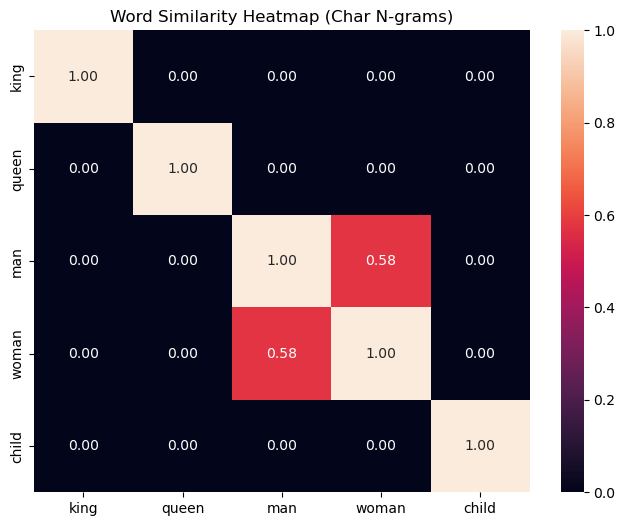

In [112]:
words = ["king", "queen", "man", "woman", "child"]

# Will keep the words that exist
words = [w for w in words if w in word_vectors]

sim_matrix = []
for w1 in words:
    row = []
    for w2 in words:
        row.append(cosine_similarity(word_vectors[w1], word_vectors[w2]))
    sim_matrix.append(row)

df = pd.DataFrame(sim_matrix, index=words, columns=words)

plt.figure(figsize=(8, 6))
sns.heatmap(df, annot=True, fmt=".2f")
plt.title("Word Similarity Heatmap (Char N-grams)")
plt.show()

# Analysis

The heatmap helps to show us that some words have a higher similarity than other words. This is seen especially when they share spelling patterns. Words that share common character chunks, examples “MAN” and “WOMAN” share “MAN”) can come out closer.

Because these vectors are built from character n-grams instead, and not pretrained embeddings. The similarity is mostly based on form/spelling rather than meaning. This notebook shows how word vectors can be compared mathematically and visualized.

# Reflection

The notebook helped me to understand how word vectors can be created and used when the dataset only contains a lexicon. The similarity and heatmap results made more sense to me after building vectors from character n-grams, since it gave each word real numeric feature.

Something I acknowledged, was that the approach compares words mostly by spelling patterns, so it will not always solve semantic analogies the way "Word2Vector" embeddings do. It was useful for practicing cosine similarity, vector mathematics, and visualizing the results with the heatmap.